In [1]:
from math import sqrt
from random import random, randrange, seed

In [2]:
import matplotlib
import seaborn
import pandas

In [3]:
from models import *
from methods import *

In [4]:
seaborn.set(style="darkgrid")
matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.serif"] = ["Times New Roman"]

In [5]:
seed(0)

In [6]:
num_professions = 2  # This is a constant; changing it requires
                     # further code modifications
num_agents = 100
prof1 = 50
prof2 = num_agents - prof1
professions = [0] * prof1 + [1] * prof2
num_localities = 10  # Fix localities to 10 localities with cap 10 each
locality_caps = [10] * 10
random_samples = 1000

def _distribute_jobs(prof1_jobs, prof2_jobs):
    job_numbers = [(0, 0)] * num_localities
    for _ in range(prof1_jobs):
        l = randrange(num_localities)
        prof1, prof2 = job_numbers[l]
        job_numbers[l] = (prof1 + 1, prof2)
    for _ in range(prof2_jobs):
        l = randrange(num_localities)
        prof1, prof2 = job_numbers[l]
        job_numbers[l] = (prof1, prof2 + 1)
        
    return job_numbers
    
def test_correction(prof1_jobs, prof2_jobs):
    job_numbers = _distribute_jobs(prof1_jobs, prof2_jobs)
    qualification_probabilities = \
        [[random()] * num_localities for _ in range(num_agents)]
    correction_functions = []
    for p1, p2 in job_numbers:
        # The default parameters in the lambdas are never used, but are
        # a way of getting Python's peculiar binding behavior to work.
        # See https://docs.python.org/3/faq/programming.html#why-do-
        # lambdas-defined-in-a-loop-with-different-values-all-return-
        # the-same-result for more information.
        correction_functions.append((lambda x, P1=p1: min(x, P1),
                                     lambda x, P2=p2: min(x, P2)))
    model = RetroactiveCorrectionModel(num_agents, locality_caps,
                                       num_professions, professions,
                                       qualification_probabilities,
                                       correction_functions,
                                       random_samples)
    return model

def test_interview(prof1_jobs, prof2_jobs):
    job_numbers = _distribute_jobs(prof1_jobs, prof2_jobs)
    compatibility_probabilities = [random() for _ in range(num_agents)]
    model = InterviewModel(num_agents, locality_caps, num_professions,
                           professions, job_numbers,
                           compatibility_probabilities, random_samples)
    return model

def test_coordination(prof1_jobs, prof2_jobs):
    job_numbers = _distribute_jobs(prof1_jobs, prof2_jobs)
    locality_num_jobs = [prof1 + prof2 for prof1, prof2 in job_numbers]
    compatibility_probabilities = []
    for _ in range(prof1):
        competency = random()
        compatibility_probabilities.append(
            [[competency] * p1 + [0.] * p2 for p1, p2 in job_numbers])
    for _ in range(prof2):
        competency = random()
        compatibility_probabilities.append(
            [[0.] * p1 + [competency] * p2 for p1, p2 in job_numbers])
    model = CoordinationModel(num_agents, locality_caps,
                              locality_num_jobs,
                              compatibility_probabilities,
                              random_samples)
    return model

settings = {"correction": test_correction, "interview": test_interview,
            "coordination": test_coordination}

In [7]:
data = []

def sample(setting, prof1_jobs, prof2_jobs):
    m = settings[setting](prof1_jobs, prof2_jobs)
    additive = additive_optimization(m)[1]
    greedy = greedy_algorithm(m)[1]
    datum = {}
    datum["jobs in profession 1"] = prof1_jobs
    datum["jobs in profession 2"] = prof2_jobs
    datum["additive"] = additive
    datum["greedy"] = greedy
    if additive > 0.0005:
        datum["greedy / additive"] = greedy / additive
    else:
        datum["greedy / additive"] = None
    datum["model"] = setting
    data.append(datum)
    return datum

In [8]:
for _ in range(5):
    for prof1_jobs in [25, 50, 75]:
        for prof2_jobs in [25, 50, 75]:
            for k in settings:
                sample(k, prof1_jobs, prof2_jobs)

Academic license - for non-commercial use only


In [9]:
def _format_y(ratio):
    return f"{ratio-1:,.0%}"

def plot():
    d = pandas.DataFrame(data)
    g = seaborn.catplot(x="jobs in profession 1", 
                        y="greedy / additive", hue="model",
                        col="jobs in profession 2", data=d)
    for ax in g.axes[0]:
        vals = ax.get_yticks()
        ax.set_yticklabels([_format_y(x) for x in vals])
        ax.set_ylabel("improvement of greedy over additive")
    g.savefig("job_availability.pdf")

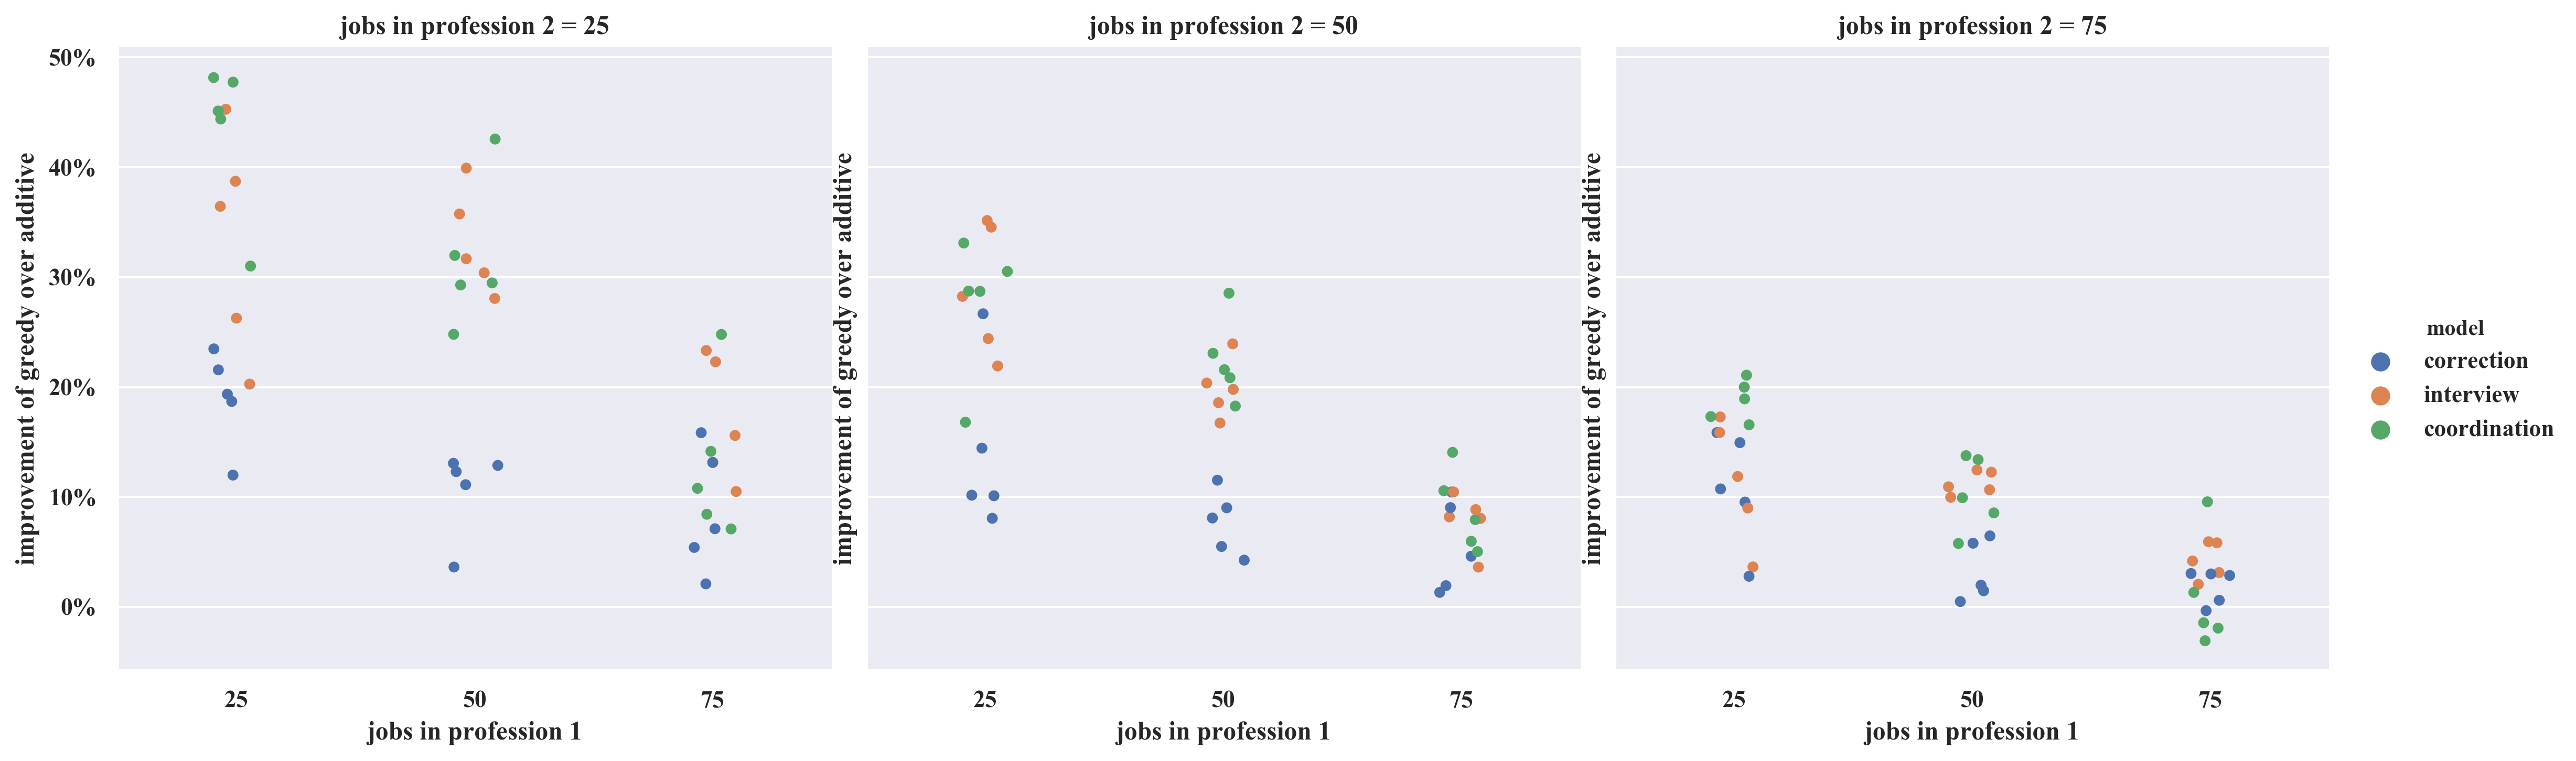

In [10]:
plot()

In [11]:
def plot_absolute_utilities():
    d = pandas.DataFrame(data)
    g = seaborn.catplot(x="jobs in profession 1", y="additive",
                        hue="model", col="jobs in profession 2",
                        data=d)
    g.savefig("job_availability_additive.pdf")

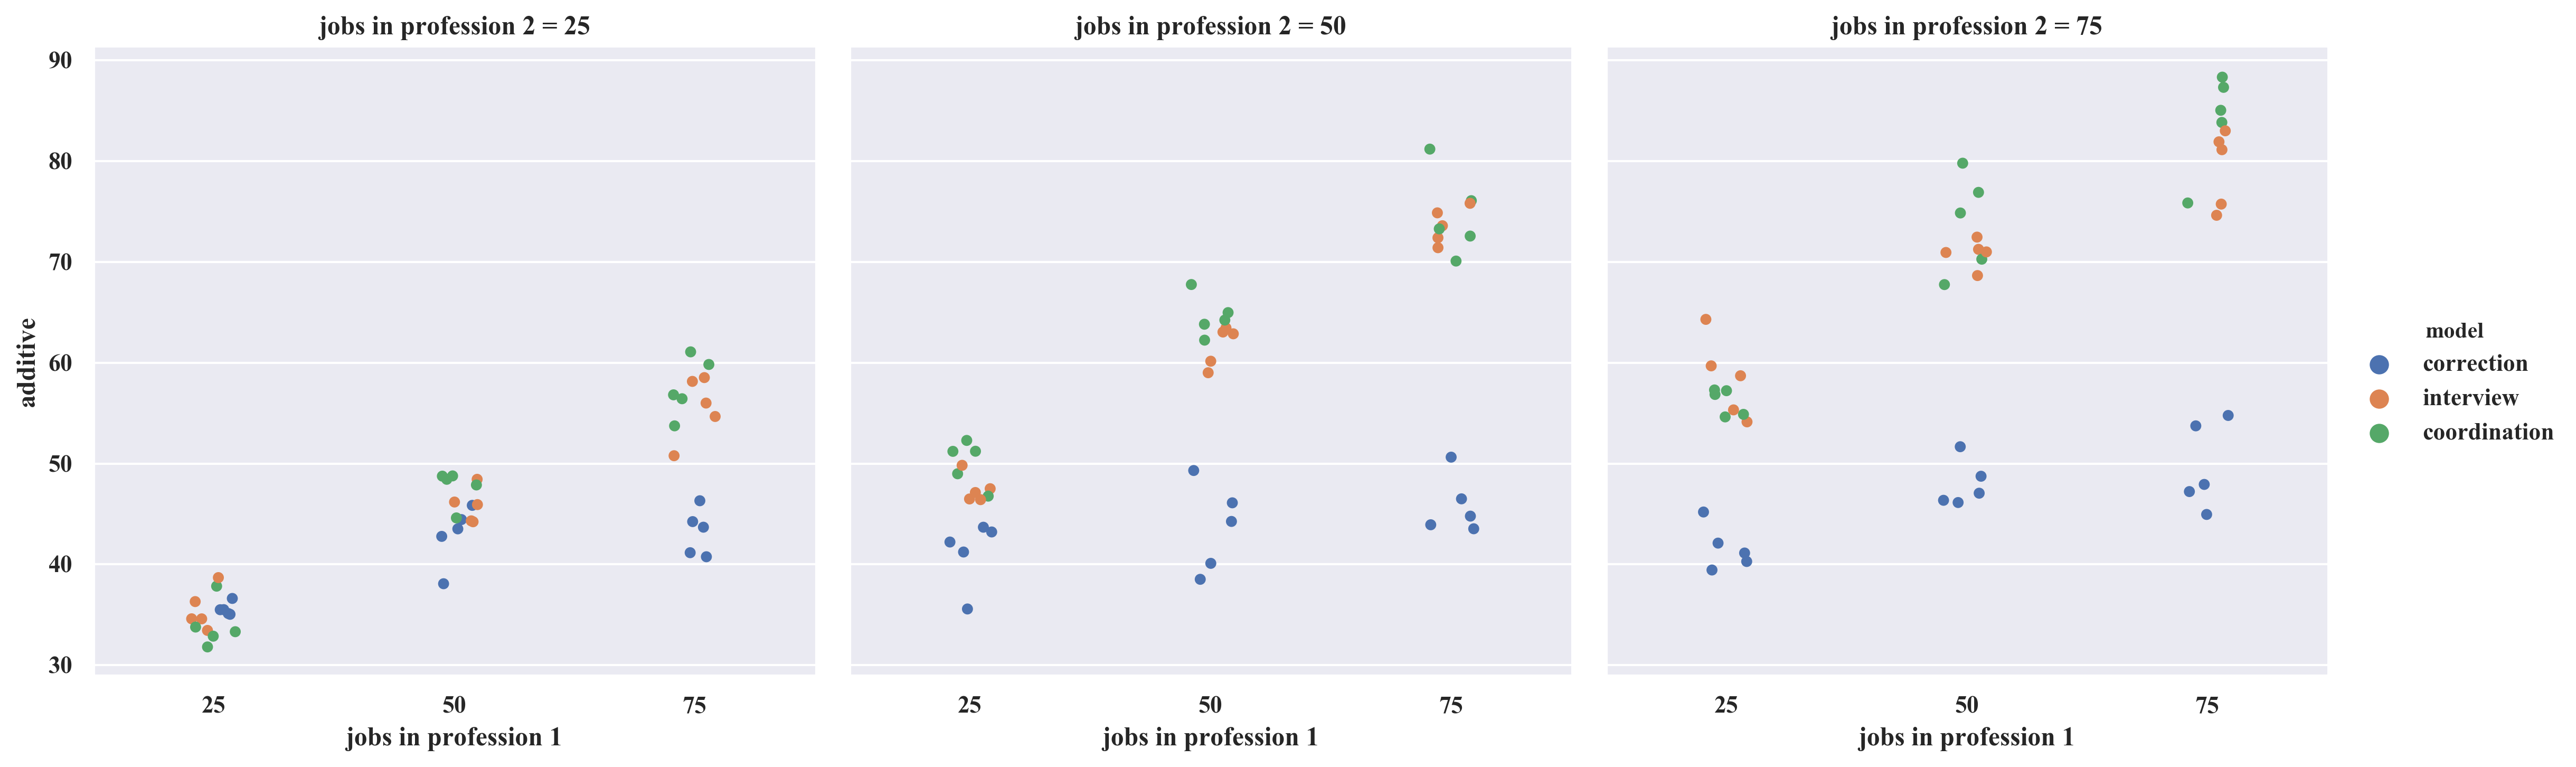

In [12]:
plot_absolute_utilities()